# TF Record 로 저장하기 (tensorflow record)
http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

https://github.com/warmspringwinds/tensorflow_notes

## 1 Pic file <--> ndarray 
이미지를 ndarray로 변환 및 복원

skimage 로 해야 변환 및 복구가 용이

matplotlib 는 string 변환등은 되지만 복구가 안된다 (string 변환시 header 내용도 다르다)

(328, 451, 3)


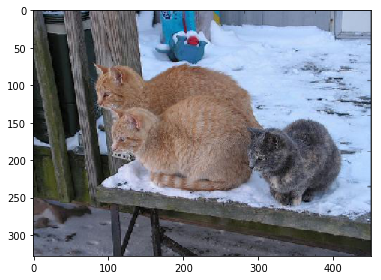

In [1]:
%matplotlib inline
import numpy as np

# image 파일을 ndarray 로 변환 01 (scikit-image)
import skimage.io as io  
cat_img = io.imread('./data/cats.png')
io.imshow(cat_img)

# # image 파일 불러오기 02 (pip install pillow 를 해야 png 이외도 인식가능)
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# cat_img = mpimg.imread('./data/cats.png')
# plt.imshow(cat_img) #, cmap='gray')

print(cat_img.shape)

In [2]:
# ndarray.tostring() : '이미지'를 string representation 으로 변환
cat_string = cat_img.tostring()
print(type(cat_string), '\t') ; cat_string[:100]

<class 'bytes'> 	


b"435FEI65988<88=338/0701923;34<13;35>-/8\x1b\x1f(\t\r\x15\x02\x03\x0e\x03\x04\x0f\x0f\x12\x1e69FUXeMP]#'4\x18\x1b(\x07\x08\x14\x04\x06\x10\x08\x0b\x14\x00\x02\t\x03\x06\r\x04\x08\x0f\x02\x05\r\x00\x01\t\x07\n\x14\n\x0f\x19\x08"

In [3]:
# string 을 image 로 재변환 
# 주의!!: 특정한 dtype 만 변환가능하므로, 일부분만 변환시 오류가 발생한다
# 재변환은 1차원 데이터로만 변환되므로, ndarray 의 size 값을 지정할 필요가 있다
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)
reconstructed_cat_1d

array([52, 51, 53, ..., 33, 33, 35], dtype=uint8)

In [4]:
# 위의 1차원 데이터를 입체로 복원
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)
reconstructed_cat_img.shape

(328, 451, 3)

In [5]:
# 원본과 재변환 데이터의 일치여부를 확인
import numpy as np
np.allclose(cat_img, reconstructed_cat_img)

True

## 2  list 파일들을 읽어서 .tfrecord 를  생성하기
TF_Record 로 simple 객체들 저장 및 복원하기

In [6]:
# 이미지 목록 샘플 리스트
filename_pairs = [
('./data/2007_000032.jpg','./data/2007_000032.png'),
('./data/2007_000039.jpg','./data/2007_000039.png'),
('./data/2007_000063.jpg','./data/2007_000063.png')]
filename_pairs 

[('./data/2007_000032.jpg', './data/2007_000032.png'),
 ('./data/2007_000039.jpg', './data/2007_000039.png'),
 ('./data/2007_000063.jpg', './data/2007_000063.png')]

In [7]:
%matplotlib inline
# indexed 로 정렬된 png 파일을 PIL 로 변환 할 것이다.
# 기타 방법으로 skimage.io.imread() 를 활용하면 된다
from PIL import Image
import tensorflow as tf
import numpy as np
import skimage.io as io

In [8]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [9]:
tfrecords_filename = './data/pascal_voc_segmentation.tfrecords' # tfrecords 저장할 파일이름
writer = tf.python_io.TFRecordWriter(tfrecords_filename)
original_images = []

In [10]:
# ( jpg 파일 , png 간략이미지 ) 로 TF-Record 작성
for img_path, annotation_path in filename_pairs:
    # jpg 정보 추출
    img = np.array(Image.open(img_path)) # jpg -> ndarray
    height = img.shape[0]
    width = img.shape[1]
    img_raw = img.tostring()
    # png 정보 추출
    annotation = np.array(Image.open(annotation_path)) # png -> ndarray
    annotation_raw = annotation.tostring()
    # [original_images] : 정확도 측정을 위한 list 데이터
    original_images.append((img, annotation))

    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    writer.write(example.SerializeToString())

In [11]:
writer.close() # TF-Redaer 작성 완료
reconstructed_images = []
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
record_iterator  # <tf_record_iterator> 객체 (반복 가능한 객체) 를 생성 - type : string

<generator object tf_record_iterator at 0x7f03c7cb0410>

In [12]:
# TF-Record 의 이미지들을 불러오기 ==> Image로 재복원 한다
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height'].int64_list.value[0])
    width = int(example.features.feature['width'].int64_list.value[0])
    img_string = (example.features.feature['image_raw'].bytes_list.value[0])
    annotation_string = (example.features.feature['mask_raw'].bytes_list.value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations (png 이미지) 는 깊이 값이 없다 (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))

In [13]:
print(len(reconstructed_images) , len(reconstructed_images[0])) # 튜플 이 3개인 list 객체

3 2


In [14]:
# 원본객체와 TF-Record 복원 객체의 일치여부 확인
for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))

True
True
True
True
True
True


## 3 .tfrecords  데이터를 batch 로 불러오기
to define the Graph

batch 사이즈에 따라 대상을 랜덤하게 추출한다 (머신러닝의 기초)

https://stackoverflow.com/questions/35028173/how-to-read-images-with-different-size-in-a-tfrecord-file

In [15]:
%matplotlib inline
import tensorflow as tf
import skimage.io as io
IMAGE_HEIGHT = 384;    IMAGE_WIDTH = 384
tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

In [16]:
def read_and_decode(filename_queue):   # TF-Record 객체에서 내용을 불러온다
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example , # tf.parse_single_example : 1개 이미지만 추출
                    features={'height': tf.FixedLenFeature([], tf.int64),
                              'width': tf.FixedLenFeature([], tf.int64),
                              'image_raw': tf.FixedLenFeature([], tf.string),
                              'mask_raw': tf.FixedLenFeature([], tf.string) })
    # TF-Record 에서 불러온 scalar string 을 Tensor 로 변환
    height = tf.cast(features['height'], tf.int32)
    width  = tf.cast(features['width'], tf.int32)

    image      = tf.decode_raw(features['image_raw'], tf.uint8)
    image_shape = tf.stack([height, width, 3])
    image = tf.reshape(image, image_shape)
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)

    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    annotation_shape = tf.stack([height, width, 1])
    annotation = tf.reshape(annotation, annotation_shape)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)

    # tf.image.resize_image_with_crop_or_pad : 객체의 크기를 통일 
    # (약간의 distortion 가능 - 가로세로 비율은 무시하고 변환하기 때문)
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                          target_height=IMAGE_HEIGHT, target_width=IMAGE_WIDTH)
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                          target_height=IMAGE_HEIGHT, target_width=IMAGE_WIDTH)

    # batch size = 2 : tf-record 에서 2개씩 랜덤하게 추출한다
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                          batch_size=2, capacity=30, num_threads=2, min_after_dequeue=10)
    return images, annotations

In [17]:
# epochs 10개씩 객체를 queue 로 불러온다
filename_queue = tf.train.string_input_producer([tfrecords_filename], num_epochs=10)
# Even when reading in multiple threads, share the filename from queue.
image, annotation = read_and_decode(filename_queue)
# # 변수값들을 초기화.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

(384, 384, 3) current batch
0 time batch is done ============================================================ 


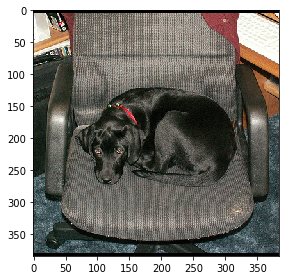

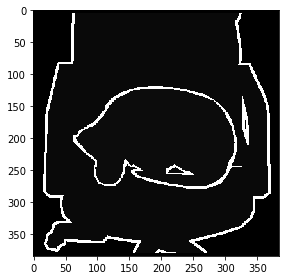

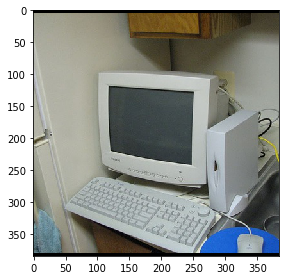

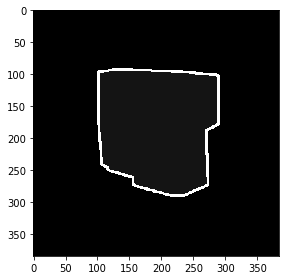

(384, 384, 3) current batch
1 time batch is done ============================================================ 


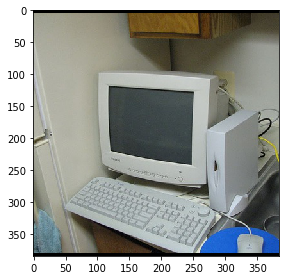

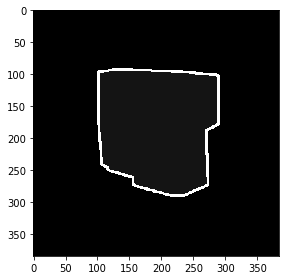

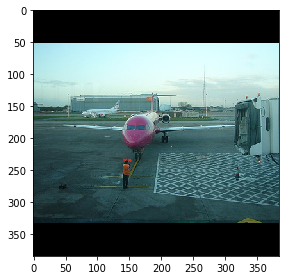

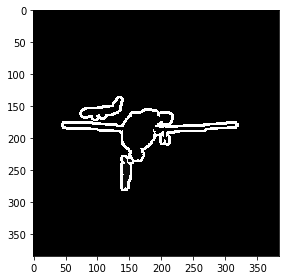

(384, 384, 3) current batch
2 time batch is done ============================================================ 


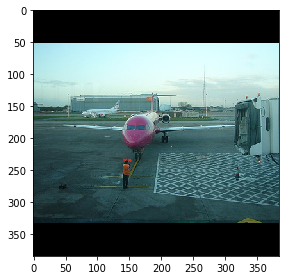

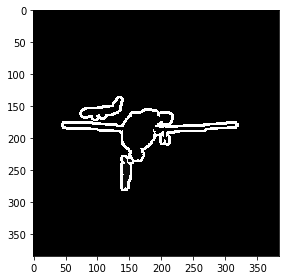

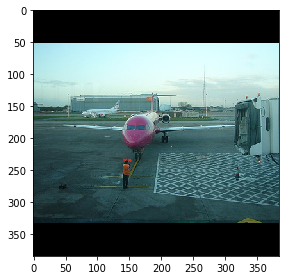

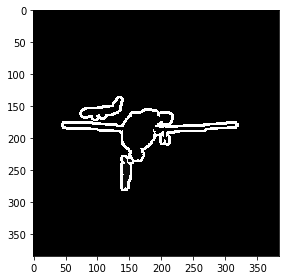

In [18]:
with tf.Session()  as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Let's read off 3 batches just for example
    for i in range(3):    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape , 'current batch')
        print( i , 'time batch is done','='*60, '\n','='*80)
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random
        io.imshow(img[0, :, :, :])   ; io.show()
        io.imshow(anno[0, :, :, 0])  ; io.show()
        io.imshow(img[1, :, :, :])   ; io.show()
        io.imshow(anno[1, :, :, 0])  ; io.show()
    coord.request_stop()
    coord.join(threads)